In [1]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron

FileNotFoundError: [Errno 2] No such file or directory: '/content/r_packages.tar.gz'

In [ ]:
! pip install --user phate scprep gseapy

In [2]:
import pandas as pd
import numpy as np

import phate
import scprep
import gseapy

import matplotlib.pyplot as plt
import seaborn as sns

import time, os, tarfile

# matplotlib settings for Jupyter notebooks only
%matplotlib inline


## Identifying branch-specific gene trends in the Treutlein fibroblast data

In this exercise, we will Slingshot on a dataset of 392 cells generated from trans-differentiating fibroblasts from [Treutlein et al. _Nature_. 2016](http://doi.org/10.1038/nature18323). This data was already preprocessed and downloaded from the [Dynverse quickstart tutorial](https://dynverse.org/users/2-quick_start/).

Briefly, a variety of transcription factors were overexpressed in Mouse Embryonic Fibroblasts (MEFs) to induce neuronal differentiation. Cells were sampled at several intervals over 22 days of differentation and sequenced using the Fluidigm C1 system and the SMART-seq protocol.

Once we have identified the three branches in this dataset, we are going to use DREMI to identify branch-specific trends in gene expression.

## Loading and visualizing the data

#### Download data from Google Drive

In [3]:
home = os.path.expanduser('~')
download_path = os.path.join(home, 'scRNAseq', '2014_Treutlein_Fibroblast.tar.gz')

# Download the data tarball
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1WzEva0PM95an9hKiwgQydV_df0P_g63Q',download_path)

# Extract data directory
tf = tarfile.open(download_path)
tf.extractall(os.path.dirname(download_path))

# Format the data paths
data_dir = os.path.join(os.path.dirname(download_path), '2014_Treutlein_Fibroblast_induced_neural_differentation')

data_path = os.path.join(data_dir, 'Treutlein.expression.csv')
metadata_path  = os.path.join(data_dir, 'Treutlein.groups.csv')

#### Read in the data using `pandas`

In [4]:
data = pd.read_csv(data_path, index_col=0)

metadata = pd.read_csv(metadata_path, index_col=0)
metadata.columns = pd.Index(['annotated_clusters'])

#### Run PHATE

In [5]:
phate_op = phate.PHATE(knn=5, n_jobs=-2)

data_phate = phate_op.fit_transform(data)
data_phate = pd.DataFrame(data_phate, index=data.index)

Calculating PHATE...
  Running PHATE on 392 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.23 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.32 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 0.04 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 1.73 seconds.
Calculated PHATE in 2.11 seconds.


## Running Slingshot

Here we're just going to run the minimal code to run Slingshot with four clusters. For a more in depth tutorial, please see the TrajectoryInference series.



#### Generate Clusters

In [6]:
clusters = phate.cluster.kmeans(phate_op, n_clusters=5)
metadata['cluster'] = clusters

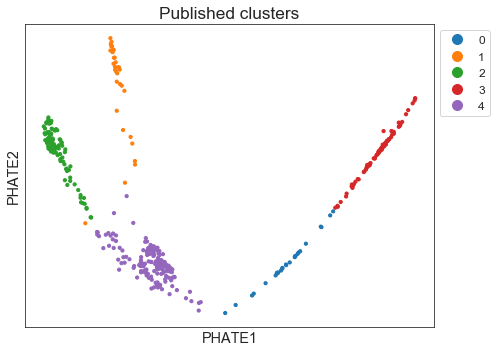

In [7]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['cluster'],
                 label_prefix='PHATE', ticks=None,
                 title='Published clusters', legend_anchor=(1,1),
                 figsize=(7,5))

#### Run Slingshot

In [8]:
results = scprep.run.Slingshot(data_phate, metadata['cluster'])

R[write to console]: Using full covariance matrix


#### Grab output from `results` dictionary

In [9]:
results.keys()

dict_keys(['pseudotime', 'curves', 'branch'])

In [10]:
pseudotime = results['pseudotime']
metadata['slingshot1'] = pseudotime.iloc[:,0]
metadata['slingshot2'] = pseudotime.iloc[:,1]

metadata['slingshot_branch'] = results['branch']

#### Plotting the principal curves and branch pseudotimes


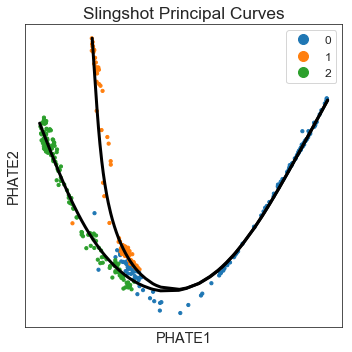

In [11]:
ax = scprep.plot.scatter2d(data_phate, c=metadata['slingshot_branch'],
                 label_prefix='PHATE', ticks=None,
                 title='Slingshot Principal Curves',
                 figsize=(5,5))

# `results['curves']` returns as tensor (an array of arrays)
# Each array contains coordinates for the curves in the dimensionality reduced space
for curve in results['curves']:
    ax.plot(curve[:,0], curve[:,1], c='k', linewidth=3)

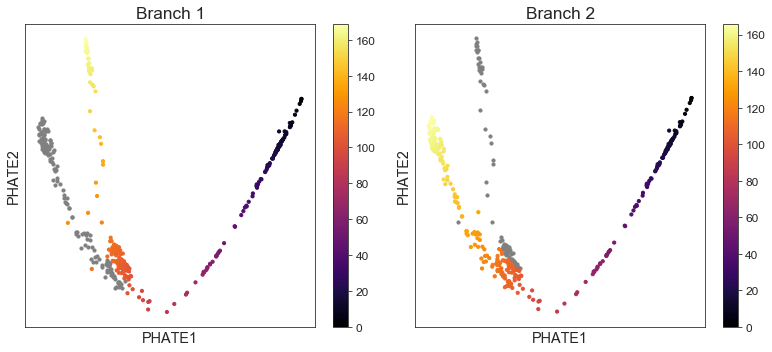

In [12]:
fig, axes = plt.subplots(1,2, figsize=(11,5))

for i, ax in enumerate(axes):
    curr_pseudotime = metadata['slingshot{}'.format(i+1)]
    m = ~pd.isnull(curr_pseudotime)
    # plot null points as grey
    scprep.plot.scatter2d(data_phate[~m], color='grey', s=10,
                          ax=ax)    
    # plot points on branch
    scprep.plot.scatter2d(data_phate[m], c=curr_pseudotime[m], s=10,
                         label_prefix='PHATE', ticks=None,
                          title='Branch {}'.format(i + 1),
                          ax=ax)
    
fig.tight_layout()

## Identifying branch-specific changes in gene expression

Now that we have our slingshot results, we can start using DREMI to identify genes with strong statistical association with pseudotime on each branch. DREMI is an estimate of mutual information designed to work with the sparsity of data in single-cell experiments. There is an implementation of DREMI in `scprep` at `scprep.stats.knnDREMI`.


#### Create masks for each of the branches

In [13]:
branch0 = results['branch'] == 0
branch1 = results['branch'] == 1 
branch2 = results['branch'] == 2

#### Calculating kNN-DREMI for each branch

This will take some time because we calculate kNN-DREMI on all genes three times.

In [14]:
dremi_branch0 = np.zeros(data.shape[1])
dremi_branch1 = np.zeros(data.shape[1])
dremi_branch2 = np.zeros(data.shape[1])

data_branch0 = data.loc[branch0]
data_branch1 = data.loc[branch1]
data_branch2 = data.loc[branch2]

pseudotime_branch0 = results['pseudotime'].loc[branch0].mean(axis=1)
pseudotime_branch1 = results['pseudotime'].loc[branch1][0]
pseudotime_branch2 = results['pseudotime'].loc[branch2][1]

for i, gene in enumerate(data):
    dremi_branch0[i] = scprep.stats.knnDREMI(pseudotime_branch0, data_branch0[gene])
    dremi_branch1[i] = scprep.stats.knnDREMI(pseudotime_branch1, data_branch1[gene])
    dremi_branch2[i] = scprep.stats.knnDREMI(pseudotime_branch2, data_branch2[gene])

/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/python3.7/site-packages/scprep/stats.py:201: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  UserWarning)
/home/dan/.local/lib/p

#### Calculate the difference between DREMI scores on branch 1 and branch 2
How do you calculate the difference between the branch1 and branch2 DREMI scores?

In [15]:
diff = 

#### Get the genes with highest association with each branch

You will need to write the code to concatenate the arrays

In [16]:
branch0_genes = data.columns[np.argsort(dremi_branch0)[::-1][:30]]
# Here we sort by the difference in DREMI scores to get the most negative values
branch1_genes = data.columns[np.argsort(diff)[::-1][:10]]

# Here we sort by the difference in DREMI scores to get the largest values
branch2_genes = data.columns[np.argsort(diff)[:10]]

# ========
# Add code to concatenate the lists of genes for each branch
# Make sure the output is a 1-dimensional array
interesting_genes = 
# ========

#### Reordering the dataset by branch

In [17]:
pseudotime_order = np.zeros(data.shape[0], dtype=int)
raw_indices = np.arange(data.shape[0], dtype=int)

block_masks = [branch0, (branch1 & ~branch2), (branch2 & ~branch1)]

block_start = 0
for block_mask in block_masks:
    block_len = np.sum(block_mask)
    block_end = block_start + block_len
    pseudotime_order[block_start:block_end] = raw_indices[block_mask][np.argsort(results['pseudotime'].loc[block_mask].sum(axis=1))]
    block_start = block_end

#### Creating a `clustermap` of the top genes

Here, you'll need to add code to calculate the average pseudotime for each point.

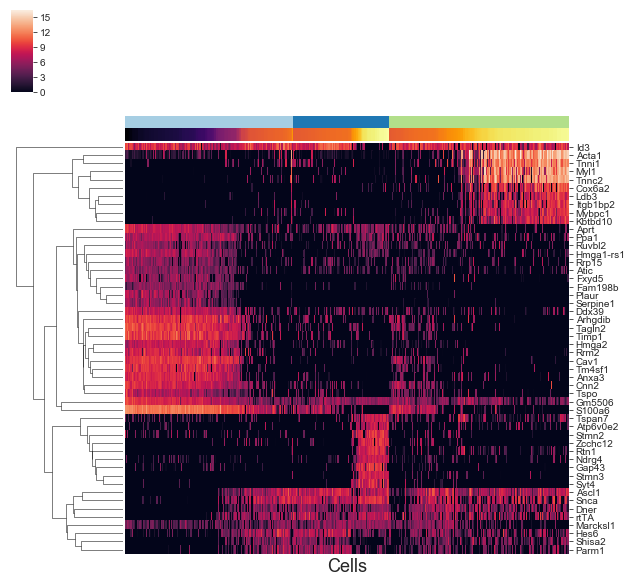

In [23]:
# Creating colors for each column
branch_cmap = {0:'#a6cee3', 1:'#1f78b4', 2:'#b2df8a'}
branch_colors = np.array([branch_cmap[b] for b in results['branch']])

# =======
# Add code to alculate average pseudotime per cell here
mean_pseudotime = #results['pseudotime'].mean(axis=1)

# =======
pseudotime_colors = plt.cm.inferno(mean_pseudotime/np.max(mean_pseudotime))

cg = sns.clustermap(data.iloc[pseudotime_order][interesting_genes].T, 
               col_colors=[branch_colors[pseudotime_order], pseudotime_colors[pseudotime_order]], 
                    col_cluster=False,
                   yticklabels=data.iloc[pseudotime_order][interesting_genes].T.index,
                   xticklabels=[])

cg.ax_heatmap.set_xlabel('Cells', fontsize=18)

cg.fig.set_size_inches(15,15)

## Gene set enrichment

Although this heatmap is nice and interesting, it is also important to make sure that these genes are biologically interesting. Now, we're going to use EnrichR to perform gene set enrichment on the genes that are unique to each branch. There are many ways to perform gene set enrichement analysis, but we're going to focus on EnrichR. The following test from [Chen E, et al. BMC Bioinformatics (2013)](https://doi.org/10.1186/1471-2105-14-128) describes how EnrichR calculates gene set enrichement.

> **Computing enrichment**  
Enrichr implements three approaches to compute enrichment. The first one is a standard method implemented within most enrichment analysis tools: the Fisher exact test. This is a proportion test that assumes a binomial distribution and independence for probability of any gene belonging to any set. The second test is a correction to the Fisher exact test that we developed based on intuition. We first compute enrichment using the Fisher exact test for many random input gene lists in order to compute a mean rank and standard deviation from the expected rank for each term in each gene-set library. Then, using a lookup table of expected ranks with their variances, we compute a z-score for deviation from this expected rank, this can be a new corrected score for ranking terms. Alternatively, we combined the p-value computed using the Fisher exact test with the z-score of the deviation from the expected rank by multiplying these two numbers as follows:

$$c=log(p)\cdot z$$

>Where $c$ is the combined score, $p$ is the p-value computed using the Fisher exact test, and $z$ is the z-score computed by assessing the deviation from the expected rank. Enrichr provides all three options for sorting enriched terms. In the results section, we show how we evaluated the quality of each of these three enrichment methods by examining how the methods rank terms that we know should be highly ranked.

### Getting gene sets from https://amp.pharm.mssm.edu/Enrichr/
In this exercise, we're going to leave colab for a little bit to introduce you to the HTML5 version of EnrichR. 

1. For each branch, get a list of 100 "interesting" genes [as calculated above](#Get-the-genes-with-highest-association-with-each-branch).
2. Print out the list in the following code block
3. Copy the gene symbols
4. Copy them into https://amp.pharm.mssm.edu/Enrichr/
5. Examine gene set enrichment for each Gene Ontology (GO) category under the "Ontologies" tab

Using these lists, can you determine which branch is the differentiating muscle cells and the differentiating neurons?

In [37]:
for gene in branch0_genes:
    print(gene)

Tm4sf1
Ascl1
Anxa3
Hmga1-rs1
Plaur
Hmga2
Tagln2
Cav1
Snca
Serpine1
Fam198b
Aprt
Gm5506
S100a6
Rrm2
Cnn2
Dner
Shisa2
Ruvbl2
Ddx39
rtTA
Tspo
Hes6
Atic
Arhgdib
Timp1
Parm1
Rrp15
Ppa1
Fxyd5


### Running EnrichR from gseapy

There is also a handy tool for performing GSEA in Python called gseapy. Documentation for the tool is available at: https://gseapy.readthedocs.io/en/master/

#### Getting the enrichement for all the "interesting genes" used in the heatmap above

In [31]:
# gseapy needs the gene list as a list, not np.array
gene_list = list(interesting_genes)
gseapy.enrichr(gene_list, 'GO_Biological_Process_2018', outdir='Enrichr')
# Load the output into a DataFrame
enrichr_results = pd.read_csv('./Enrichr/GO_Biological_Process_2018..enrichr.reports.txt', sep='\t')

#### Examining the output table

What do you notice about the genes enriched in each category? How does overlap affect the Combined Score?

In [40]:
enrichr_results = enrichr_results.sort_values('Combined Score', ascending=False).reset_index(drop=True)
enrichr_results.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,muscle filament sliding (GO:0030049),5/39,4.293339e-08,0.000219,0,0,51.282051,869.929024,ACTA1;MYBPC1;MYL1;TNNC2;TNNI1
1,GO_Biological_Process_2018,actin-myosin filament sliding (GO:0033275),5/39,4.293339e-08,0.000110,0,0,51.282051,869.929024,ACTA1;MYBPC1;MYL1;TNNC2;TNNI1
2,GO_Biological_Process_2018,negative regulation of microtubule polymerizat...,2/9,2.180466e-04,0.222538,0,0,88.888889,749.404597,STMN2;SNCA
3,GO_Biological_Process_2018,regulation of platelet-derived growth factor r...,2/10,2.721231e-04,0.173581,0,0,80.000000,656.740484,NDRG4;SNCA
4,GO_Biological_Process_2018,negative regulation of reproductive process (G...,2/10,2.721231e-04,0.198378,0,0,80.000000,656.740484,ARHGDIB;TIMP1


#### Plot a bar chart of the  10 highest Combined Score values

You'll need to add code for:
1. Select the first 10 rows of the DataFrame
2. Getting the `'Combined Score'` from the `row` variable
3. Completing the command to `ax.bar` to get a **vertical** bar chart.

[Text(0, 0, 'muscle filament sliding (GO:0030049)'),
 Text(0, 0, 'actin-myosin filament sliding (GO:0033275)'),
 Text(0, 0, 'negative regulation of microtubule polymerization (GO:0031115)'),
 Text(0, 0, 'regulation of platelet-derived growth factor receptor signaling pathway (GO:0010640)'),
 Text(0, 0, 'negative regulation of reproductive process (GO:2000242)'),
 Text(0, 0, 'regulation of trophoblast cell migration (GO:1901163)'),
 Text(0, 0, 'regulation of muscle contraction (GO:0006937)'),
 Text(0, 0, 'negative regulation of smooth muscle cell migration (GO:0014912)'),
 Text(0, 0, 'negative regulation of platelet-derived growth factor receptor signaling pathway (GO:0010642)'),
 Text(0, 0, 'microtubule depolymerization (GO:0007019)')]

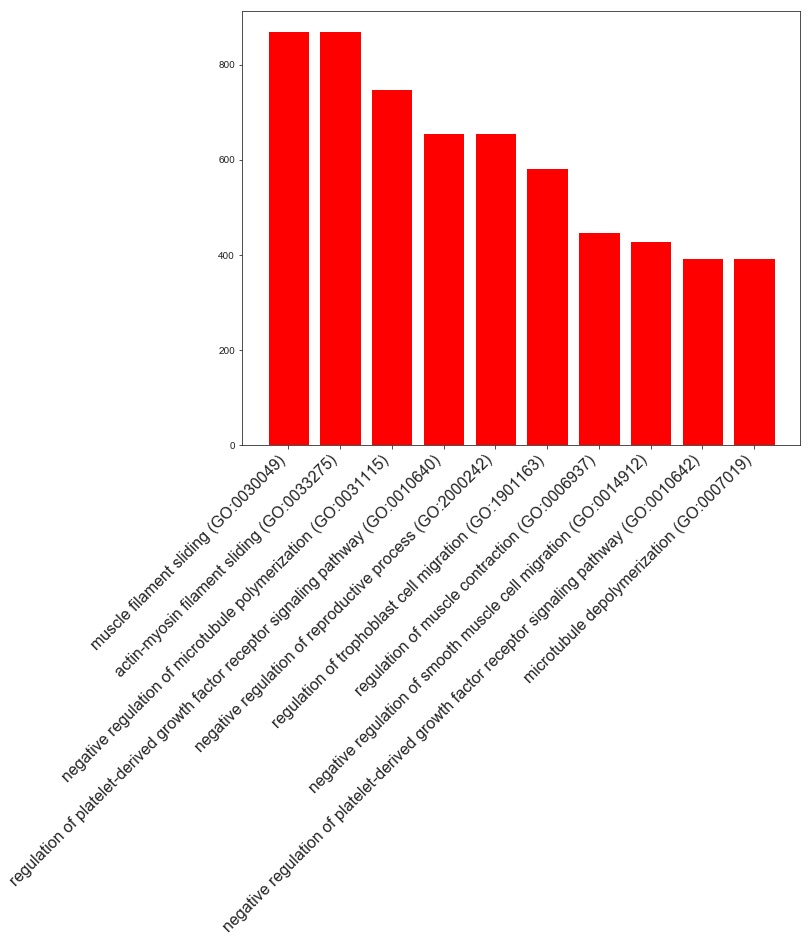

In [53]:
fig, ax = plt.subplots(1, figsize=(10,8))
# ======
# Select the first 10 rows from `enrichr_results`
top_genes = 
ticks = []
ticklabels = []

for i, row in top_genes.iterrows():
    # Get the 'Combined Score' value from the row
    combined_score =
    ax.bar(x= , y= , color='red')

    # Append the x position to the ticks list
    ticks.append(i)
    # Append the 'term' column to the ticklabels list
    ticklabels.append(row['Term'])

ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontsize=16)
# ======